# Displacement Analysis

In [3]:
# !pip install h5py
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install sklearn
# !pip install numpy
# !pip install scipy
# !pip install sleap==1.2.6

In [1]:
import h5py
import numpy as np
# import sleap
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
# !wget -O displacement_analysis.h5 https://github.com/rdiazrincon/SLEAP_Data/blob/master/displacement_analysis/displacement_analysis.h5

--2021-01-04 03:24:05--  https://github.com/talmolab/sleap/raw/main/docs/notebooks/analysis_example/predictions.analysis.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/talmolab/sleap/main/docs/notebooks/analysis_example/predictions.analysis.h5 [following]
--2021-01-04 03:24:05--  https://raw.githubusercontent.com/talmolab/sleap/tree/main/docs/notebooks/analysis_example/predictions.analysis.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 551501 (539K) [application/octet-stream]
Saving to: ‘predictions.analysis.h5’

predictions.analysi 100%[===================>] 538.58K  --.-KB/s    in 0.05s   


In [2]:
path = "displacement_analysis.h5"

## Loading the data

In [3]:
with h5py.File(path, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(path)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
displacement_analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']

===locations data shape===
(54546, 6, 2, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In our example file, the shape of the locations matrix (the `tracks` dataset) is (3000, 13, 2, 2) **after it is transposed** (with the `.T`). We transpose the data when loading it in Python; no transpose is needed when using MATLAB. This is because Python and MATLAB expect matrices to be stored differently.

Here's what each dimension of the matrix means:

- 3000: the number of frames;

- 13: the number of nodes in the skeleton (we've also loaded and displayed the `node_names` dataset with the names of these 13 nodes);

- 2: for the x and y coordinates;

- 2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn't work as well).

We can get these counts from the shape of the matrix, like so:


In [4]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 54546
node count: 6
instance count: 2


Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

In [5]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [6]:
locations = fill_missing(locations)

## Visualize thorax movement across video

In [7]:
NOSE_INDEX = 0
THORAX_INDEX = 1
FOREHEAD_INDEX = 2

nose_loc = locations[:, NOSE_INDEX, :, :]
thorax_loc = locations[:, THORAX_INDEX, :, :]
forehead_loc = locations[:, FOREHEAD_INDEX, :, :]

In [8]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Nose tracks')

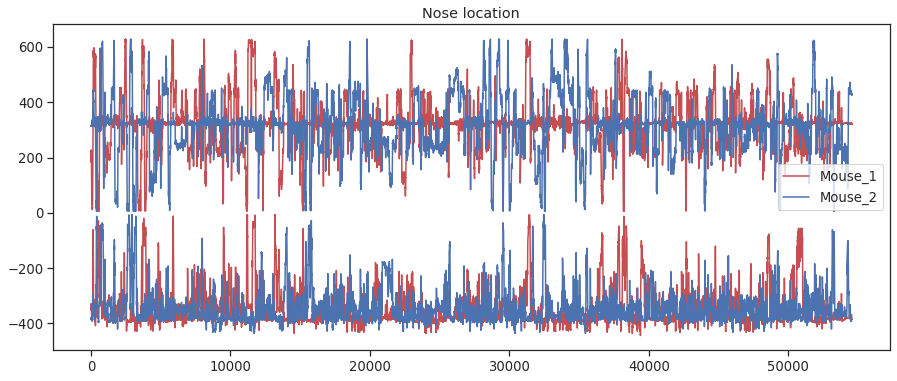

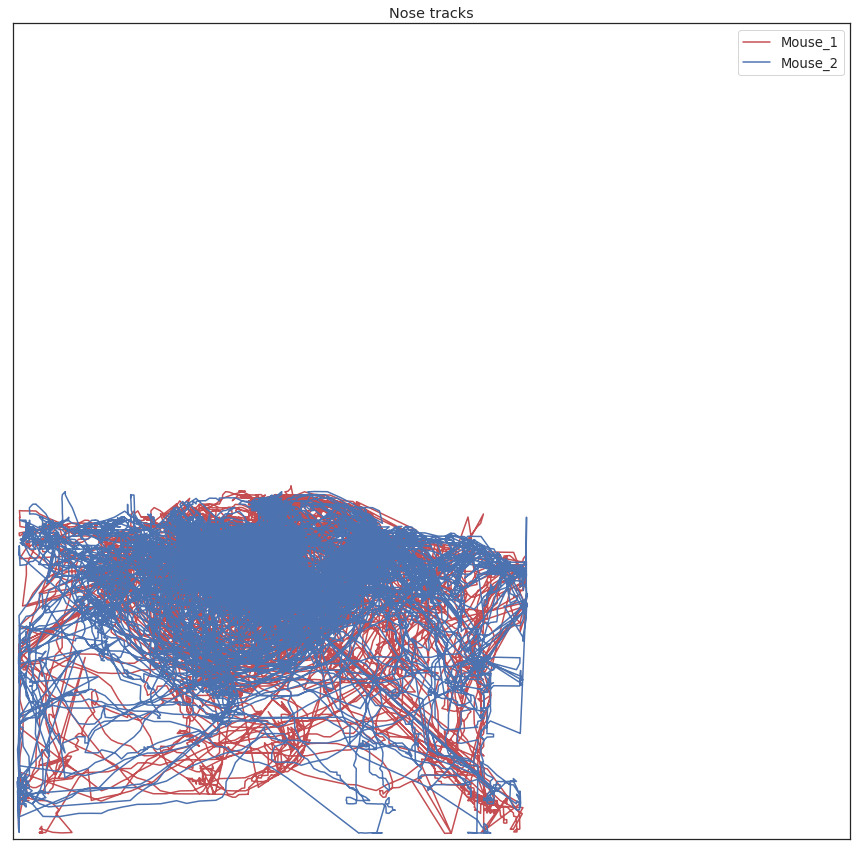

In [29]:
plt.figure()
plt.plot(nose_loc[:,0,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1], 'b',label='Mouse_2')

plt.plot(-1*nose_loc[:,1,0], 'r')
plt.plot(-1*nose_loc[:,1,1], 'b')

plt.legend(loc="center right")
plt.title('Nose location')


plt.figure(figsize=(15,15))
plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1],nose_loc[:,1,1], 'b',label='Mouse_2')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Nose tracks')

## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [10]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two mice. Let's get results for each separately.

In [11]:
thx_vel_mouse1 = smooth_diff(thorax_loc[:, :, 0])
thx_vel_mouse2 = smooth_diff(thorax_loc[:, :, 1])

### Visualizing thorax x-y dynamics and velocity for Mouse_1

Text(0.5, 1.0, 'Velocity')

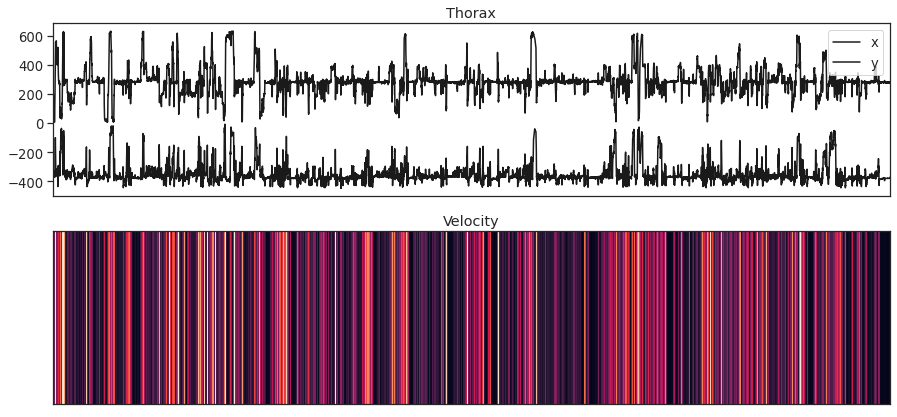

In [12]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(thx_vel_mouse1[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of Mouse speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of Mouse speed')

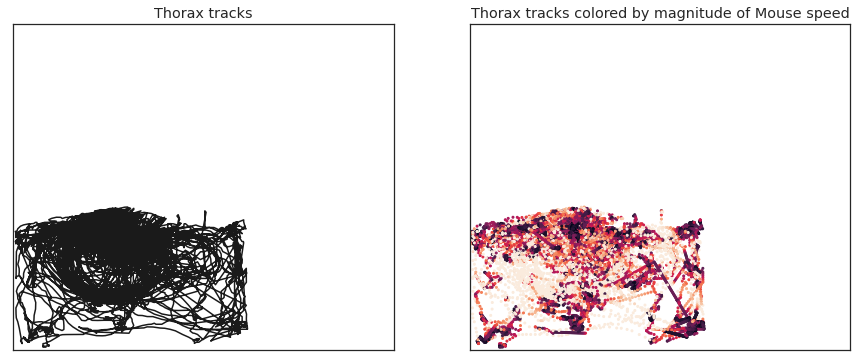

In [24]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_mouse1 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of Mouse speed')

### Find covariance in thorax velocities between Mouse_1 and Mouse_2

In [14]:
import pandas as pd

def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

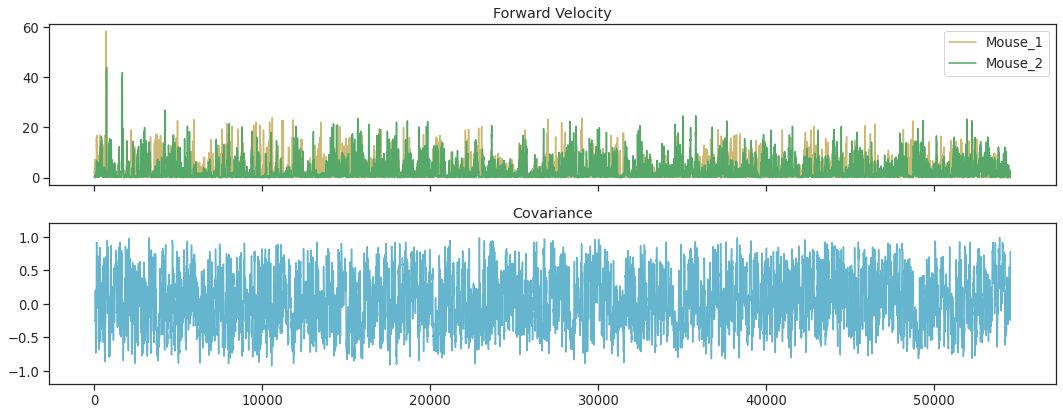

In [15]:
win = 50

cov_vel = corr_roll(thx_vel_mouse1, thx_vel_mouse2,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_mouse1, 'y', label='Mouse_1')
ax[0].plot(thx_vel_mouse2, 'g', label='Mouse_2')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run simple k-means on the velocities from each frame.


In [16]:
def instance_node_velocities(instance_idx):
    mouse_node_locations = locations[:, :, :, instance_idx]
    mouse_node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        mouse_node_velocities[:, n] = smooth_diff(mouse_node_locations[:, n, :])
    
    return mouse_node_velocities

In [17]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Mouse {instance_idx} node velocities')

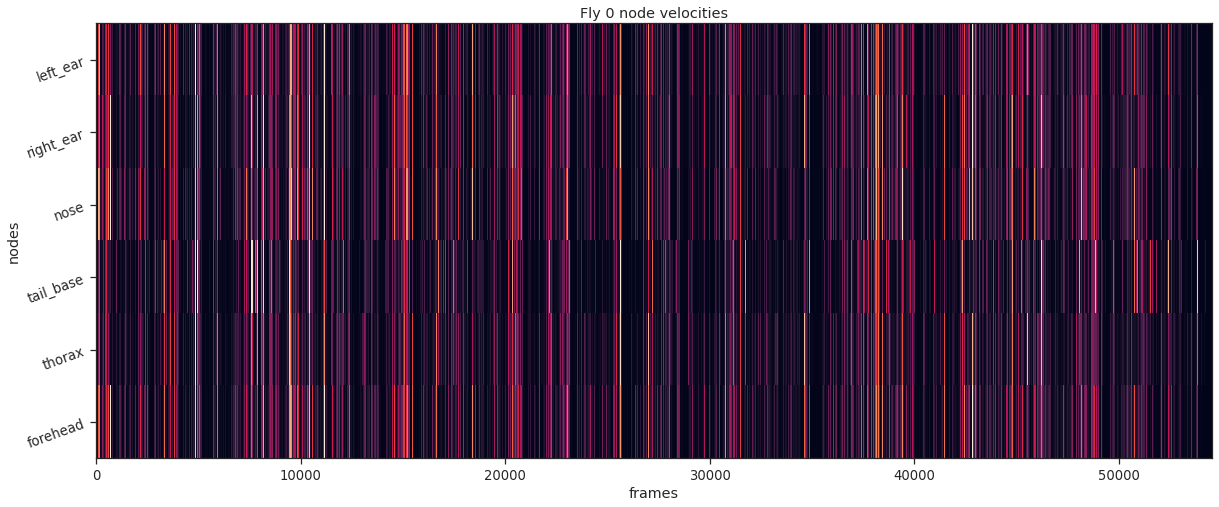

In [19]:
mouse_ID = 0
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

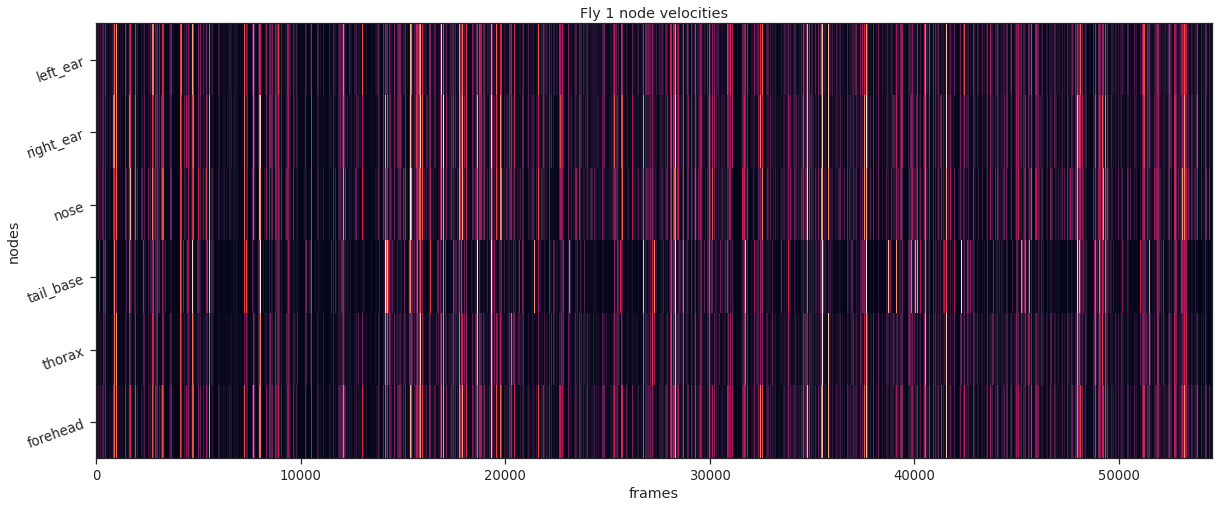

In [20]:
mouse_ID = 1
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

In [21]:
from sklearn.cluster import KMeans

In [22]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(mouse_node_velocities)

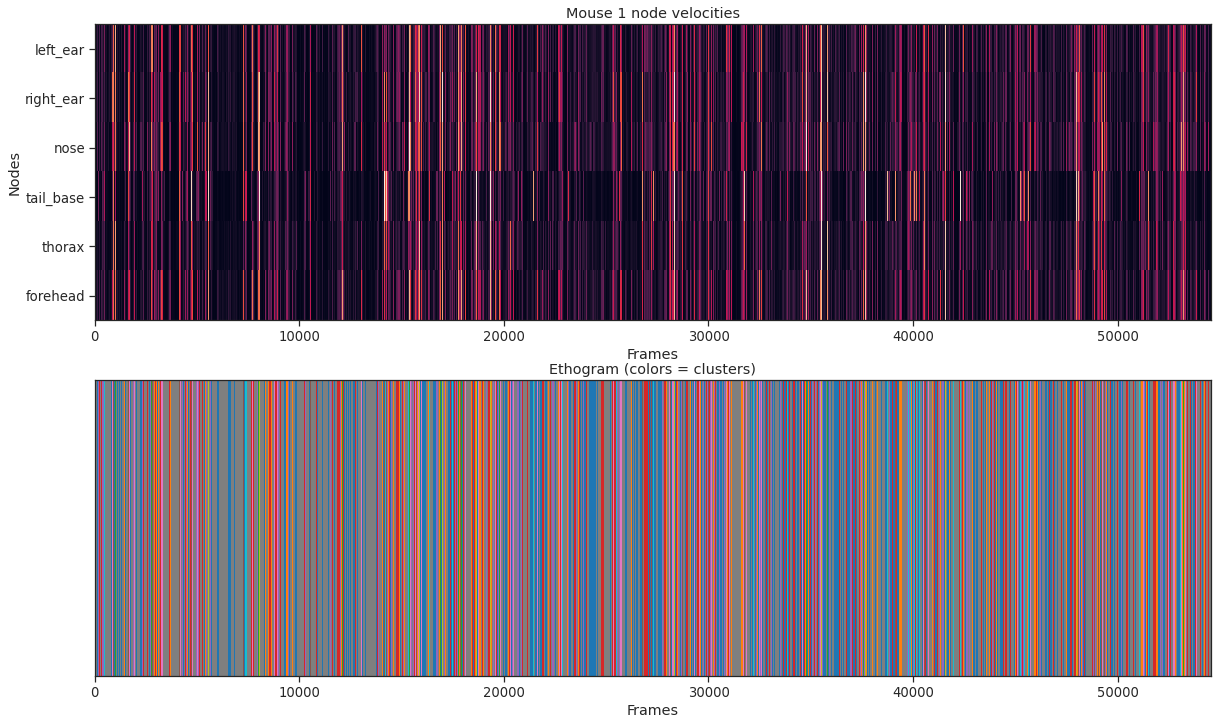

In [23]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(mouse_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(node_count))
ax1.set_yticklabels(node_names);
ax1.set_title(f"Mouse {mouse_ID} node velocities")
ax1.set_xlim(0,frame_count)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");